In [ ]:

import sympy as sm
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

dtype  = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = 'cpu'
sympyTorchmodules = {'sin': torch.sin, 'cos': torch.cos}


### 1D Poisson PDE Class

\begin{align}
u_{xx} &= f(x), \hspace{1.3cm} x \in \Omega \\
u(x) &= g(x), \hspace{1.3cm} x \in \partial \Omega
\end{align}

Where: 

\begin{align}
    f(x) &= -a^{2}\pi^{2}\sin(a\pi x), \hspace{0.2cm} x \in [0,1] \\
    g(x) &= 0, \hspace{2.3cm} x = 0,1
\end{align}

In [ ]:
class Poisson1D:

    def __init__(self, a=None):

        self.setup_equations()
        self.setup_residuals()

        if a != None:
            self.a = 1

    def setup_equations(self, f_eqn=None, g_eqn=None):
        ### Setup

        # Variables/Coefficients
        a   = sm.symbols('a'); 

        # PDE States
        x   = sm.symbols('x')      # domain
        # xbc = sm.symbols('x1:3')   # partial domain for boundary condition

        u   = sm.symbols('u', cls=sm.Function)(x)
        ux  = u.diff(x)
        uxx = ux.diff(x)

        # Forcing/External/Boundary/Initial condition functions
        f   = sm.symbols('f', cls=sm.Function)(x)
        g   = sm.symbols('g', cls=sm.Function)(x)

        # Set up PDE_eqn
        self.PDE_eqn = sm.Eq(uxx,f)

        # Set up boundary condition
        # bc_eq1 = sm.Piecewise((u, sm.Eq(x, xbc[0])),  (u, sm.Eq(x, xbc[1])), (0, True))
        # bc_eq2 = sm.Piecewise((g, sm.Eq(x, xbc[0])),  (g, sm.Eq(x, xbc[1])), (0, True))
        self.BC_eqn  = sm.Eq(u, g)

        # For reuse in class
        self.x   = x 
        # self.xbc = xbc
        self.U = [u, ux, uxx]
        self.f = f 
        self.g = g 

    def setup_residuals(self):
        pde_residual = self.PDE_eqn.lhs - self.PDE_eqn.rhs
        bc_residual  = self.BC_eqn.lhs  - self.BC_eqn.rhs

        self.pde_residual = sm.lambdify([self.x, self.U, self.f], pde_residual, modules=sympyTorchmodules)
        self.bc_residual  = sm.lambdify([self.x, self.U, self.g], bc_residual,  modules=sympyTorchmodules)        

##### Define exact, source and boundary condition functions

In [ ]:
def f_u_exact(a,x):
    """ 
    Exact solution
    """
    u_exact = torch.sin(a*torch.pi*x)
    u_exact.to(device)

    return u_exact

def f_x(a, x):
    """
    Source/Forcing function
    """
    fx = -(a**2)*(torch.pi**2)*torch.sin(a*torch.pi*x)
       
    return fx

def g_x(x, xb):
    """
    Boundary condition
    """
    
    ub = torch.zeros(x.size(), dtype=dtype)

    xb1_idx = torch.where(x == xb[0])[0]
    xb2_idx = torch.where(x == xb[1])[0]

    ub[xb1_idx] = 0
    ub[xb2_idx] = 0

    return ub

#### PINN Class

In [ ]:
class PINN(nn.Module):
    def __init__(self, input_size, output_size, neurons, PDE):
        super(PINN, self).__init__()

        # Define layers of network
        self.layer1     = nn.Linear(input_size, neurons)
        self.layer2     = nn.Linear(neurons, output_size)

        self.layers = [self.layer1, self.layer2]

        self.activation = nn.Tanh()      

        # import and initialize PDE
        if hasattr(PDE,'pde_residual'):
            self.pde_residual = PDE.pde_residual
        if hasattr(PDE, 'bc_residual'):
            self.bc_residual = PDE.bc_residual
        if hasattr(PDE, 'ic_residual'):
            self.ic_residual = PDE.ic_residual

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight.data)            
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):

        for layer in self.layers[:-1]:
            x = layer(x)
            x = self.activation(x)

        x = self.layers[-1](x)

        return x
    
    def backward(self, X, U, f=None, g=None, h=None):


        if X.shape[1] == 2:
            xr = X[:, 0].view(-1,1)
            xb = X[:, 1].view(-1,1)
        else:
            xr = xb = X

        if len(U.shape) == 3:
            U_x = U[0].T
            U_b = U[1].T
        else:
            U_x = U.T
            U_b = U.T

        loss = []

        if hasattr(self, 'pde_residual') and f != None:
            residual        = self.pde_residual(xr, U_x, f).T
            self.pde_loss   = torch.mean(residual**2)
        
            loss.append(self.pde_loss)

        if hasattr(self, 'bc_residual') and g !=None:
            residual        = self.bc_residual(xb, U_b, g).T
            self.bc_loss    = torch.mean(residual**2)
        
            loss.append(self.bc_loss)   

        if hasattr(self, 'ic_residual') and h != None:
            residual        = self.ic_residual(X, U, h).T
            self.ic_loss    = torch.mean(residual**2)
            loss.append(self.ic_loss)

        loss = torch.stack(loss, dim=0).sum()

        loss.backward()

        self.loss = loss

    def compute_NTK(self, X, U):

        if X.shape[1] == 2:
            xr = X[:, 0].view(-1,1)
            xb = X[:, 1].view(-1,1)
        else:
            xr = xb = X

        if len(U.shape) == 3:
            U_x = U[0].T
            U_b = U[1].T
        else:
            U_x = U.T
            U_b = U.T


        if hasattr(self, 'pde_residual'):

            f   = torch.zeros(xr.size()).T.to(device)   
            L_u = self.bc_residual(xr, U_x, f) 
            J_r = torch.autograd.grad()

            K_rr = torch.mul(J_r, J_r.T)

        if hasattr(self, 'bc_residual'):

            g   = torch.zeros(xb.size()).T.to(device) 
            u   = self.bc_residual(xr, U_x, f) 
            # J_u = torch.autograd.grad()

            K_rr = torch.mul(J_r, J_r.T)
        
    #     J_u 

    #     K = 

                    



In [ ]:
from torch.utils.data import DataLoader, RandomSampler

In [ ]:
## Setup PDE Equation
a   = 2
PDE = Poisson1D(a)

# Define PDE domain
X_0,X_N = 0.,1.
X_bc  = [X_0, X_N]
# dx  = 0.002; # N   = int((X_N - X_0)/dx) 

N  = 500
Xr = torch.linspace(X_0, X_N, N, dtype=dtype, device=device, requires_grad=True).view(-1,1)
Xb = torch.randint(0, 2, (N,1),  dtype=dtype, device=device, requires_grad=True)

X  = torch.hstack((Xr, Xb))

In [26]:
## Setup PINN parameters

Nr      = 100
Nb      = 100
rand_sampler = RandomSampler(X, num_samples=Nr, replacement=True)
XTrain       = DataLoader(X, Nr, sampler=rand_sampler)

size          = len(XTrain.dataset)
learning_rate = 1e-3
epochs        = int(1)

loss_fn   = nn.MSELoss()
optimizer = optim.SGD

input_size  = 1
output_size = 1
neurons     = 10
net         = PINN(input_size, output_size, neurons, PDE)

optimizer = optimizer(net.parameters(), learning_rate)
# optimizer = optim.Adam(net.parameters(), learning_rate)


In [27]:

### TRAIN LOOP
train_losses = []

for epoch in range(epochs+1):
    net.train()
    net.to(device)

    for i, x in enumerate(XTrain):
        xr = x[:,0].view(-1,1).to(device); xb = x[:,1].view(-1,1).to(device)

        ### INTERIOR DOMAIN
        # make prediction w.r.t. interior points
        u_hat_x   = net(xr)
        
        # determine gradients w.r.t interior points
        ux_hat_x  = torch.autograd.grad(u_hat_x.sum(),  xr, create_graph=True)[0]
        uxx_hat_x = torch.autograd.grad(ux_hat_x.sum(), xr, create_graph=True)[0]
        U_x       = torch.hstack([u_hat_x, ux_hat_x, uxx_hat_x])

        # Compute forcing/source function
        fx = f_x(a, xr).T.to(device)

        ### BOUNDARY DOMAIN
        u_hat_xb    = net(xb)
        # determine gradients w.r.t boundary points
        ux_hat_xb   = torch.autograd.grad(u_hat_xb.sum(),  xb, create_graph=True)[0]
        uxx_hat_xb  = torch.autograd.grad(ux_hat_xb.sum(), xb, create_graph=True)[0]
        U_xb        = torch.hstack([u_hat_xb, ux_hat_xb, uxx_hat_xb])
        
        # compute boundary condition
        gx = g_x(xb, X_bc).T.to(device)

        U = torch.stack((U_x, U_xb), dim=0)

        # Compute NTK
        f   = torch.zeros(xr.size()).T.to(device)
        u   = net.pde_residual(xr, U_x.T, f).T
        
        print(u.shape)
        print(u)

        ## Backward step
        # Set the gradients to zero
        
        # optimizer.zero_grad()
        # net.backward(x, U, fx, gx)
        # optimizer.step()
        
        train_losses.append(net.loss.item())

    if epoch % 100 == 0 or epoch == epochs - 1: 
        print(f"Epoch: {epoch:4d}     loss: {train_losses[-1]:5f}")


torch.Size([100, 1])
tensor([[0.6404],
        [0.6568],
        [0.1751],
        [0.1374],
        [0.5657],
        [0.5938],
        [0.6762],
        [0.4104],
        [0.6261],
        [0.5902],
        [0.6675],
        [0.3714],
        [0.5922],
        [0.6121],
        [0.6263],
        [0.4717],
        [0.5827],
        [0.2964],
        [0.6805],
        [0.3657],
        [0.4291],
        [0.6177],
        [0.0497],
        [0.5105],
        [0.6287],
        [0.5997],
        [0.5967],
        [0.6532],
        [0.0284],
        [0.1512],
        [0.6412],
        [0.1025],
        [0.6759],
        [0.4571],
        [0.6361],
        [0.5920],
        [0.0000],
        [0.2901],
        [0.6782],
        [0.4717],
        [0.6702],
        [0.4394],
        [0.6819],
        [0.5274],
        [0.5548],
        [0.3511],
        [0.6820],
        [0.6694],
        [0.6817],
        [0.6097],
        [0.6680],
        [0.6245],
        [0.5191],
        [0.6586],
       

AttributeError: 'PINN' object has no attribute 'loss'

In [53]:
# Compute NTK
f   = torch.zeros(xr.size()).T.to(device)
u   = net.pde_residual(xr, U_x.T, f).T

params = {k: v for k, v in net.named_parameters()}

n = neurons 
m = len(params)
J_u = torch.zeros((n**3,n))

for i, layer_param in enumerate(params.keys()):
    theta    = params[layer_param]

    for j,u_i in enumerate(u):
        if j == 0:
            J_row   = torch.autograd.grad(u_i, theta, u_i, retain_graph=True)[0].flatten()
        else:
            J_row_i = torch.autograd.grad(u_i, theta, u_i, retain_graph=True)[0].flatten()
            J_row = torch.hstack((J_row, J_row_i))

    k = len(J_row)
    J_u[:k,i] = J_row

    # J_u[:,i] = torch.autograd.grad(u, theta, grad_outputs=torch.ones_like(u), retain_graph=True)[0].flatten().T

# tst = torch.autograd.grad(u, theta, u, retain_graph=True)[0].flatten()

K_uu = J_u @ J_u.T


In [57]:
torch.trace(K_uu)

tensor(62.0620)

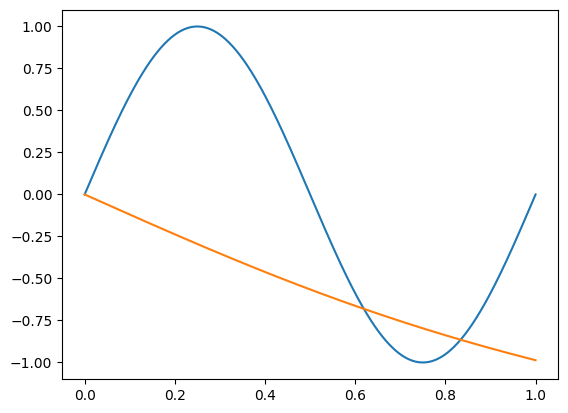

In [29]:
xplot = torch.linspace(X_0, X_N, N, requires_grad=True).view(-1,1).to(device)

# compute exact solution
u_exact = f_u_exact(a, xplot)
u_pred  = net(xplot)

xplot   = xplot.cpu().detach().numpy()
u_exact = u_exact.cpu().detach().numpy()
u_pred  = u_pred.cpu().detach().numpy()

# predict
plt.plot(xplot, u_exact, label='u_{exact}')
plt.plot(xplot, u_pred, label='u_{pred}')

plt.show()

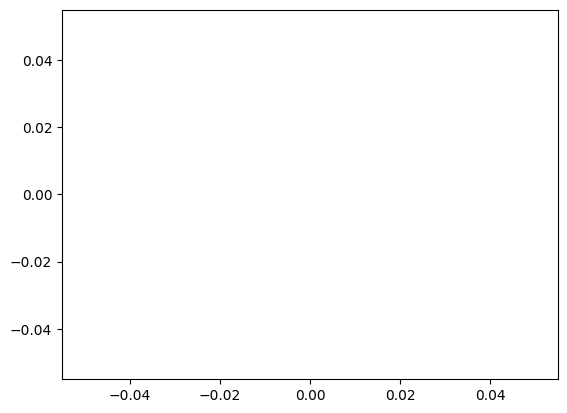

In [30]:
plt.plot(train_losses)